<a href="https://colab.research.google.com/github/segreaves/SortingAlgorithmVisualizer/blob/master/neural_networks_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification using a Neural Network
## The following is an exercise in classification using neural networks.
### Step 1: Simulate a classification problem that would be difficult to solve using conventional classification methods.

In [160]:
import numpy as np

### Simulate spiral data

In [161]:
# initialize data sets
X = []
y = []
n_clusters = 3
cluster_size = 500
n_points = cluster_size * n_clusters
noise = 0.05
theta = np.linspace(0, np.pi, cluster_size)

for i in range(n_clusters):
  r = np.linspace(0.1, 1, cluster_size)
  t = theta + (i * 4 * np.pi / n_clusters)
  xx = r * np.sin(t) + noise * np.random.randn(cluster_size)
  yy = r * np.cos(t) + noise * np.random.randn(cluster_size)

  X.extend(np.c_[xx, yy])
  y.extend([i] * cluster_size)

X = np.array(X)
y = np.array(y)

Text(0.5, 1.0, 'Spiral cluster data')

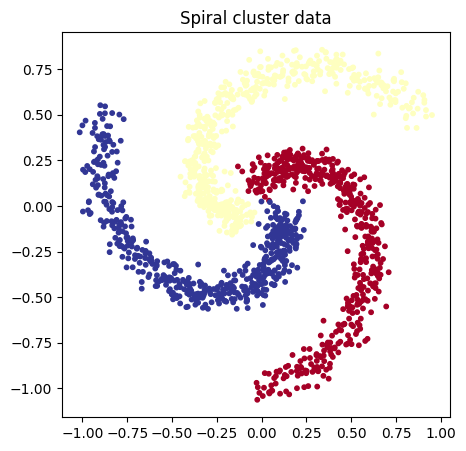

In [162]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c = y, cmap = plt.cm.RdYlBu, s = 10)
plt.title('Spiral cluster data')

# Classification using neural networks

In [163]:
import torch
from torch import nn

In [164]:
# set up device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [165]:
# set up multiclass classifier
NUM_INPUT_FEATURES = 2
NUM_CLASSES = 3

class MultiClassClassifier(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=7):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=input_features, out_features=hidden_units)
    self.layer_2 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
    self.layer_3 = nn.Linear(in_features=hidden_units, out_features=output_features)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_mcc = MultiClassClassifier(input_features=NUM_INPUT_FEATURES, output_features=NUM_CLASSES, hidden_units=10).to(device)
model_mcc

MultiClassClassifier(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=3, bias=True)
  (relu): ReLU()
)

In [166]:
# turn data into tensors
X, y = torch.from_numpy(X).type(torch.float), torch.from_numpy(y).type(torch.LongTensor)

In [167]:
# split into train and test split
from sklearn.model_selection import train_test_split
RANDOM_SEED = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=RANDOM_SEED)

In [168]:
# put data into device
X, y, X_train, X_test, y_train, y_test = X.to(device), y.to(device), X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)
next(model_mcc.parameters()).device, X.device, y.device, X_train.device, X_test.device, y_train.device, y_test.device

(device(type='cuda', index=0),
 device(type='cuda', index=0),
 device(type='cuda', index=0),
 device(type='cuda', index=0),
 device(type='cuda', index=0),
 device(type='cuda', index=0),
 device(type='cuda', index=0))

In [169]:
# set up loss function
loss_fn = nn.CrossEntropyLoss()
# set up optimizer
optimizer = torch.optim.Adam(model_mcc.parameters(), lr=0.1)
# set up the accuracy function
!pip -q install torchmetrics
from torchmetrics import Accuracy
acc_fn = Accuracy(task='multiclass', num_classes=4).to(device)

In [170]:
# set up training/test loop
torch.manual_seed = 42
torch.cuda.manual_seed = 42

epochs = 1000

# train/test loop
for epoch in range(epochs):
  ## training
  model_mcc.train()
  # forward pass
  y_train_logit = model_mcc(X_train) # logits
  y_train_pred = torch.softmax(y_train_logit, dim=1).argmax(dim=1) # predicted values

  # calculate loss
  train_loss = loss_fn(y_train_logit, y_train)
  # calculate accuracy
  train_acc = acc_fn(y_train_pred, y_train)
  # zero-out the optimizer
  optimizer.zero_grad()
  # back-propagation
  train_loss.backward()
  # optimizer step
  optimizer.step()

  ## testing
  model_mcc.eval()
  # forward pass
  y_test_logit = model_mcc(X_test) # logits
  y_test_pred = torch.softmax(y_test_logit, dim=1).argmax(dim=1) # predicted values

  # calculate the loss
  test_loss = loss_fn(y_test_logit, y_test)
  # calculate accuracy
  test_acc = acc_fn(y_test_pred, y_test)

  # print out learning progress
  if epoch % 100 == 0:
    print(f"Epoch: {epoch}, Train loss: {train_loss:.4f}, Train accuracy: {train_acc:.2f}, Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.2f}")

Epoch: 0, Train loss: 1.1342, Train accuracy: 0.32, Test loss: 1.1222, Test accuracy: 0.30
Epoch: 100, Train loss: 0.0055, Train accuracy: 1.00, Test loss: 0.0159, Test accuracy: 0.99
Epoch: 200, Train loss: 0.0027, Train accuracy: 1.00, Test loss: 0.0129, Test accuracy: 0.99
Epoch: 300, Train loss: 0.0018, Train accuracy: 1.00, Test loss: 0.0128, Test accuracy: 0.99
Epoch: 400, Train loss: 0.0014, Train accuracy: 1.00, Test loss: 0.0127, Test accuracy: 0.99
Epoch: 500, Train loss: 0.0011, Train accuracy: 1.00, Test loss: 0.0132, Test accuracy: 0.99
Epoch: 600, Train loss: 0.0009, Train accuracy: 1.00, Test loss: 0.0134, Test accuracy: 0.99
Epoch: 700, Train loss: 0.0007, Train accuracy: 1.00, Test loss: 0.0140, Test accuracy: 0.99
Epoch: 800, Train loss: 0.0006, Train accuracy: 1.00, Test loss: 0.0140, Test accuracy: 0.99
Epoch: 900, Train loss: 0.0007, Train accuracy: 1.00, Test loss: 0.0167, Test accuracy: 0.99


In [171]:
# using plot_decision_boundary function modified by mrdbourke
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.5)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

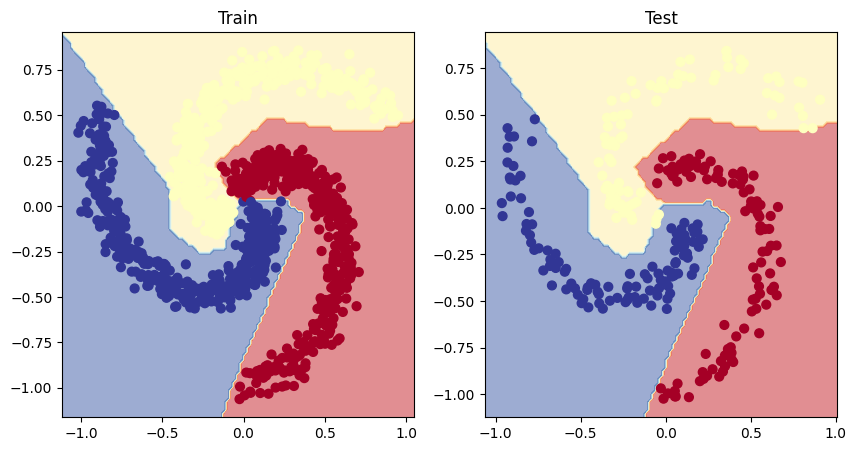

In [172]:
# plot the decision boundaries
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_mcc, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_mcc, X_test, y_test)